# Demonstrate the Aggregated Prediction Methods Using Different Classifiers

In [1]:
import helper
import aggregated_predict as ap
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
import pandas as pd
import joblib
import time
import warnings
warnings.simplefilter('ignore')

In [2]:
path = "./new_models"
os.makedirs(path, exist_ok=True)

### Train Client Model

In [3]:
rf = RandomForestClassifier()
X_train, y_train = helper.load_sensor_train_set(0)
rf.fit(X_train, y_train)
rf_filename = f'{path}/client_1.joblib'
joblib.dump(rf, filename=rf_filename)

['./new_models/client_1.joblib']

In [4]:
lr = LogisticRegression()
X_train, y_train = helper.load_sensor_train_set(1)
lr.fit(X_train, y_train)
lr_filename = f'{path}/client_2.joblib'
joblib.dump(lr, filename=lr_filename)

['./new_models/client_2.joblib']

In [5]:
gb = GradientBoostingClassifier()
X_train, y_train = helper.load_sensor_train_set(2)
gb.fit(X_train, y_train)
gb_filename = f'{path}/client_3.joblib'
joblib.dump(gb, filename=gb_filename)

['./new_models/client_3.joblib']

### Train Server Model

In [6]:
sv = svm.SVC()
X_train, y_train = helper.load_network_train_set()
sv.fit(X_train, y_train)
sv_filename = f'{path}/server.joblib'
joblib.dump(sv, filename=sv_filename)

['./new_models/server.joblib']

## 1. Testing of each model and demonstration of model aggregated prediction methods

Sensor Model 1 Prediction Results:
-----------------------------
Accuracy : 0.935854899358549
Precision: 0.9360495321163556
Recall   : 0.935854899358549
F1 Score : 0.9359263888667118
-----------------------------


Sensor Model 2 Prediction Results:
-----------------------------
Accuracy : 0.6156455061564551
Precision: 0.5945190213395155
Recall   : 0.6156455061564551
F1 Score : 0.5353481763966701
-----------------------------


Sensor Model 3 Prediction Results:
-----------------------------
Accuracy : 0.7262405072624051
Precision: 0.7235608153075249
Recall   : 0.7262405072624051
F1 Score : 0.7243480223667443
-----------------------------

Network Model Prediction Results:
-----------------------------
Accuracy : 0.9716876797168768
Precision: 0.9716697180910869
Recall   : 0.9716876797168768
F1 Score : 0.9716739444026261
-----------------------------


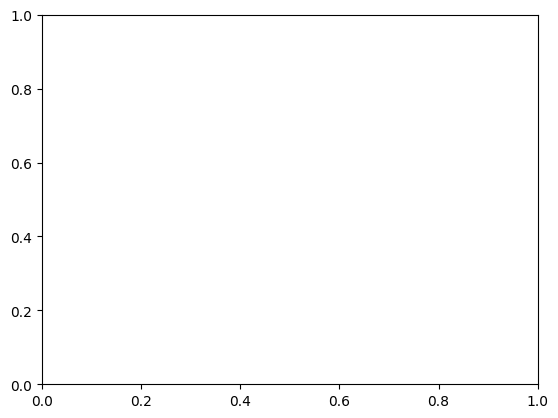

In [7]:
# Load the testing set
sensor_test, network_test = helper.load_test_set()

# Load the models
sensor_models = [rf_filename, lr_filename, gb_filename]
network_model = sv_filename

# Test models 
models_predictions, models_metrics = ap.get_predictions_and_metrics(
    local_models=sensor_models,
    sensor_test=sensor_test,
    global_model=network_model,
    network_test=network_test,
    roc=False
)

In [8]:
# Load network testing set, set the weights
y_test = network_test.iloc[:, -1]
model_weights = [0.2, 0.2, 0.2, 0.4]

In [9]:
print(f"Aggregated Prediction by Score:")
score = ap.aggregate_predict_by_score(
    models_predictions=models_predictions,
    models_metrics=models_metrics,
    models_weights=model_weights)
helper.get_metrics(y_test, score, printout=True)

Aggregated Prediction by Score:
-----------------------------
Accuracy : 0.9621273562879402
Precision: 0.9629243479395669
Recall   : 0.9621273562879402
F1 Score : 0.9618913712400916
-----------------------------


(0.9621273562879402,
 0.9629243479395669,
 0.9621273562879402,
 0.9618913712400916)

In [10]:
print(f"Aggregated Prediction by Vote:")
vote = ap.aggregate_predict_by_vote(models_predictions=models_predictions)
helper.get_metrics(y_test, vote, printout=True)

Aggregated Prediction by Vote:
-----------------------------
Accuracy : 0.8278650249453169
Precision: 0.8790722964350254
Recall   : 0.8278650249453169
F1 Score : 0.8290899173281058
-----------------------------



(0.8278650249453169,
 0.8790722964350254,
 0.8278650249453169,
 0.8290899173281058)

## 2. Simulation of Intrusion Detection in Wireless Sensor Networks

Once the WSN simulation starts, the sensors in the nodes will collect new sensing data, these data need to pass the validation of the local models first. The data that passes the validation will be sent to the server and the data that does not pass will be discarded. Once the server receives the sensed data, it will validate the sensor data and the network traffic generated by the transmitted data by aggregated prediction method to give the final validation result. If the data passes the validation, the data is saved, otherwise, the data is discarded.

In [11]:
sensor_test['target'].value_counts()

target
0    24655
1    16034
Name: count, dtype: int64

In [12]:
# Select 10000 equally distributed samples from the testing set
s0 = sensor_test[sensor_test['target'] == 0].sample(10000)
s1 = sensor_test[sensor_test['target'] == 1].sample(10000)
sampled_sensor_data = pd.concat([s0, s1])
sampled_network_data = network_test.loc[sampled_sensor_data.index]

sampled_sensor_data = sampled_sensor_data.reset_index(drop=True)
sampled_network_data = sampled_network_data.reset_index(drop=True)

print(sampled_sensor_data['target'].value_counts())
print(sampled_network_data['target'].value_counts())

target
0    10000
1    10000
Name: count, dtype: int64
target
0    10000
1    10000
Name: count, dtype: int64


In [20]:
# Use Client 1 as an example
client_1_model = joblib.load(rf_filename)
test_X = sampled_sensor_data.iloc[:, :-1]
test_y = sampled_sensor_data.iloc[:, -1]
client_1_predict = client_1_model.predict(test_X)
helper.get_metrics(test_y, client_1_predict, printout=True)

-----------------------------
Accuracy : 0.9326
Precision: 0.9327310136416902
Recall   : 0.9326
F1 Score : 0.9325948981078378
-----------------------------


(0.9326, 0.9327310136416902, 0.9326, 0.9325948981078378)

In [21]:
client_1_predict_df = pd.DataFrame(client_1_predict, columns=['Pred'])
client_1_predict_df['Pred'].value_counts()

Pred
0    10174
1     9826
Name: count, dtype: int64

In [22]:
# Client 1 will test the sensor data locally, only those that pass will be sent to the server
# Drop false data, target = 1
rows_to_keep = client_1_predict_df['Pred'] == 0
filtered_sensor_data = sampled_sensor_data[rows_to_keep]
filtered_network_data = sampled_network_data[rows_to_keep]

print(filtered_sensor_data['target'].value_counts())
print(filtered_network_data['target'].value_counts())

target
0    9413
1     761
Name: count, dtype: int64
target
0    9413
1     761
Name: count, dtype: int64


Sensor Model 1 Prediction Results:
-----------------------------
Accuracy : 0.9252014940043247
Precision: 0.8559978045078346
Recall   : 0.9252014940043247
F1 Score : 0.8892552880035441
-----------------------------


Sensor Model 2 Prediction Results:
-----------------------------
Accuracy : 0.8697660703754668
Precision: 0.8641098421571867
Recall   : 0.8697660703754668
F1 Score : 0.866911590328158
-----------------------------


Sensor Model 3 Prediction Results:
-----------------------------
Accuracy : 0.7828779241203067
Precision: 0.8769461032543191
Recall   : 0.7828779241203067
F1 Score : 0.8230445090295856
-----------------------------

Network Model Prediction Results:
-----------------------------
Accuracy : 0.9741497935915078
Precision: 0.9777012029672975
Recall   : 0.9741497935915078
F1 Score : 0.9752747524032728
-----------------------------


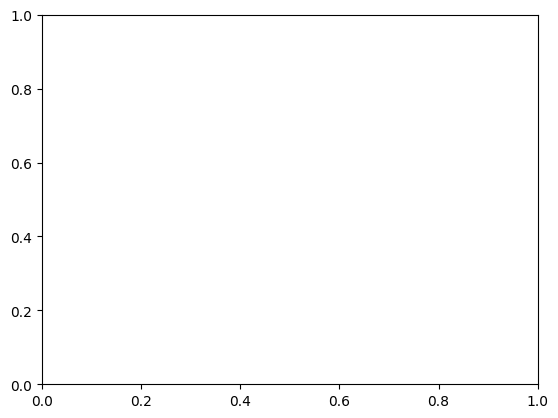

In [23]:
# Test Client 1 data using all models
new_models_predictions, new_models_metrics = ap.get_predictions_and_metrics(
    local_models=sensor_models,
    sensor_test=filtered_sensor_data,
    global_model=network_model,
    network_test=filtered_network_data,
    roc=False
)

In [24]:
# Load Client 1 network testing set, set the weights
new_y_test = filtered_network_data.iloc[:, -1]
new_model_weights = [0.4, 0.05, 0.05, 0.5]

In [26]:
print(f"Client 1 Aggregated Prediction by Score:")
start_time = time.time()

new_score = ap.aggregate_predict_by_score(
    models_predictions=new_models_predictions,
    models_metrics=new_models_metrics,
    models_weights=new_model_weights)

end_time = time.time()
rows = len(new_models_predictions[0])
time_spend = end_time - start_time

helper.get_metrics(new_y_test, new_score, printout=True)
print(f"Time spent predicting {rows} pieces of data: {time_spend} second, average time spent: {time_spend / rows} seconds.")

Client 1 Aggregated Prediction by Score:
-----------------------------
Accuracy : 0.9741497935915078
Precision: 0.9777012029672975
Recall   : 0.9741497935915078
F1 Score : 0.9752747524032728
-----------------------------


Time spent predicting 10174 pieces of data: 0.0 second, average time spent: 0.0 seconds.


In [27]:
print(f"Client 1 Aggregated Prediction by Vote:")
start_time = time.time()

new_vote = ap.aggregate_predict_by_vote(models_predictions=new_models_predictions)

end_time = time.time()
time_spend = end_time - start_time

helper.get_metrics(new_y_test, new_vote, printout=True)
print(f"Time spent predicting {rows} pieces of data: {time_spend} second, average time spent: {time_spend / rows} seconds.")

Client 1 Aggregated Prediction by Vote:
-----------------------------
Accuracy : 0.774425004914488
Precision: 0.9401477418330773
Recall   : 0.774425004914488
F1 Score : 0.8263626698710934
-----------------------------


Time spent predicting 10174 pieces of data: 0.00599980354309082 second, average time spent: 5.897192395410674e-07 seconds.
